In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os

repo_path = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(repo_path)

In [3]:
import pandas as pd
from src.portfolio_maker import HRP, IVP, MVP, ASRP
import numpy as np
from scipy.cluster.hierarchy import linkage
import matplotlib.pyplot as plt
import os


df = pd.read_csv(os.path.join('..','data','binance_usdt_pairs_2018-12-31_2024-01-01_1d.csv'))
df['close'] = pd.to_numeric(df['close'])
df["open_time"] = pd.to_datetime(df["open_time"])
df["returns"] = df.groupby("symbol")["close"].pct_change()
df.head()

,symbol,open_time,open,high,low,close,volume,close_time,quote_volume,num_trades,taker_base_vol,taker_quote_vol,ignore,returns
0,BTCUSDT,2019-01-01,3701.23,3810.16,3642.00,3797.14,23741.687033,2019-01-01 23:59:59.999,8.814925e+07,154227,12919.155899,4.797344e+07,0,NaN
1,BTCUSDT,2019-01-02,3796.45,3882.14,3750.45,3858.56,35156.463369,2019-01-02 23:59:59.999,1.338766e+08,218538,17921.600114,6.827790e+07,0,0.016175
2,BTCUSDT,2019-01-03,3857.57,3862.74,3730.00,3766.78,29406.948359,2019-01-03 23:59:59.999,1.116574e+08,199812,14793.083267,5.617250e+07,0,-0.023786
3,BTCUSDT,2019-01-04,3767.20,3823.64,3703.57,3792.01,29519.554671,2019-01-04 23:59:59.999,1.110346e+08,192232,15579.303258,5.861620e+07,0,0.006698
4,BTCUSDT,2019-01-05,3790.09,3840.99,3751.00,3770.96,30490.667751,2019-01-05 23:59:59.999,1.158935e+08,203673,14908.914175,5.666746e+07,0,-0.005551


In [4]:
# Filter symbols with NaN values after '2023-01-01'
filter_date = pd.Timestamp("2023-01-01")
filtered_symbols = df[df["open_time"] > filter_date].groupby("symbol")["returns"].apply(
    lambda x: x.isna().any()
)
symbols_to_exclude = filtered_symbols[filtered_symbols].index
filtered_df = df[~df["symbol"].isin(symbols_to_exclude)]
filtered_returns_matrix = filtered_df.pivot_table(
    index="open_time", 
    columns="symbol", 
    values="returns"
)

In [5]:
filtered_returns_matrix_post_2023 = filtered_returns_matrix.loc[filtered_returns_matrix.index > filter_date].dropna(axis=1)
filtered_returns_matrix_post_2023.drop('EURUSDT', axis=1, inplace=True)

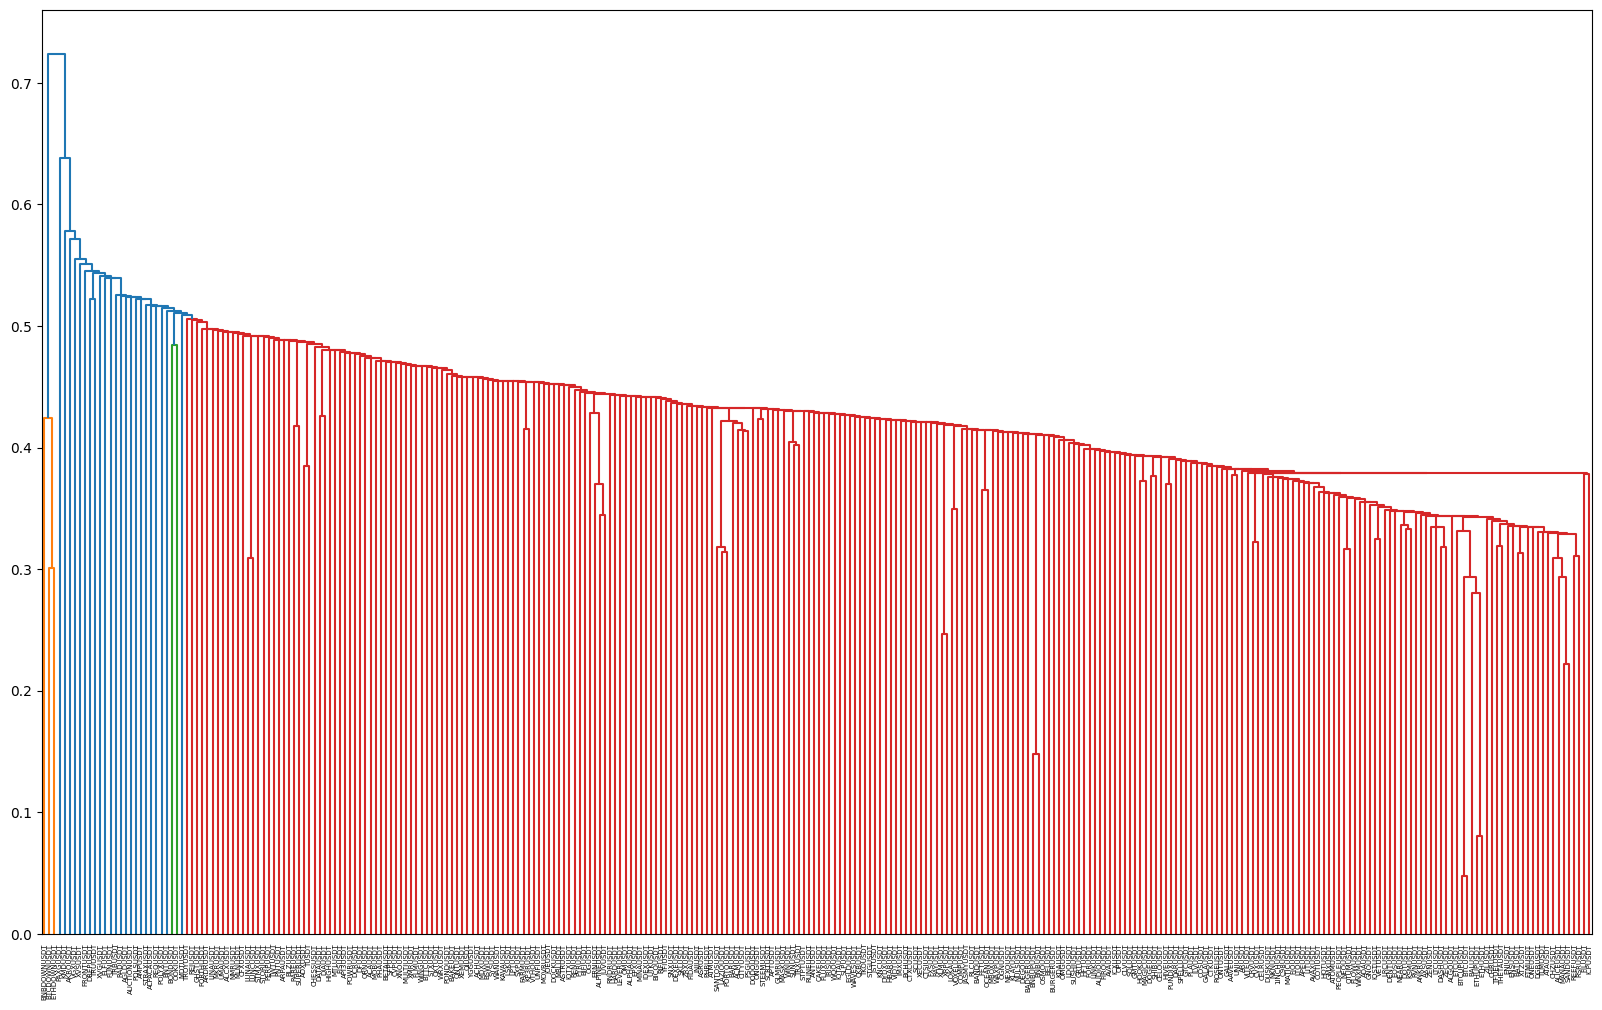

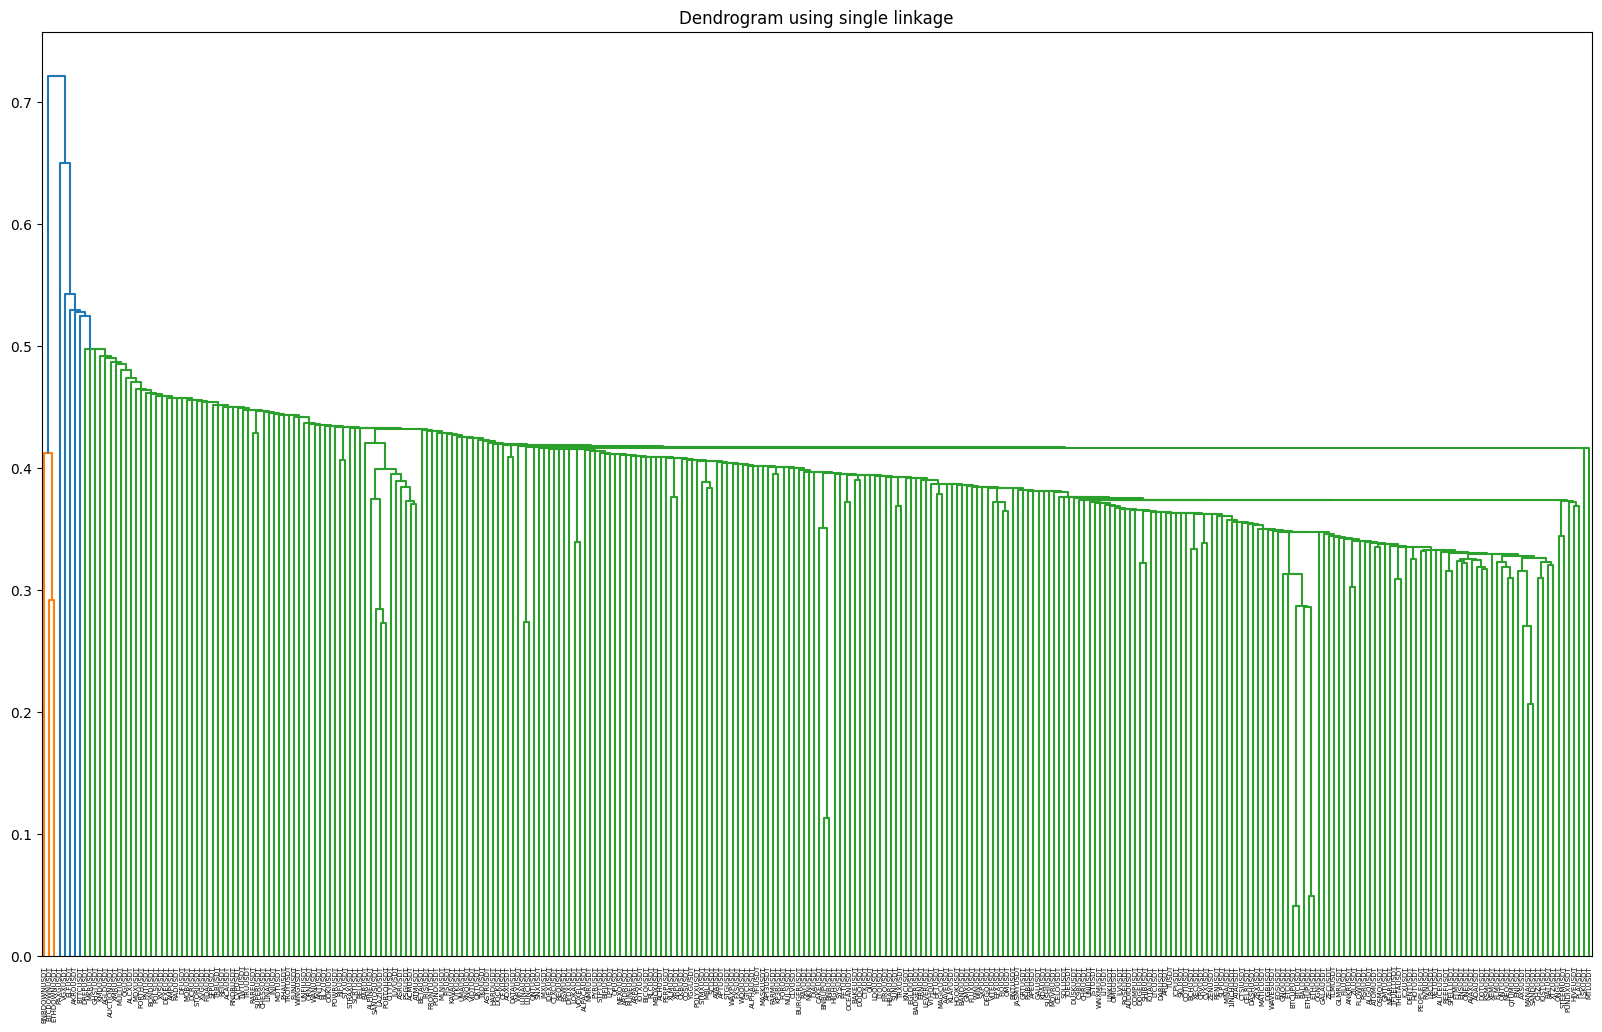

In [6]:
hrp_strategy = HRP(filtered_returns_matrix_post_2023)
hrp_weights = hrp_strategy.get_weights()

ivp_strategy = IVP(filtered_returns_matrix_post_2023)
ivp_weights = ivp_strategy.get_weights()

mvp_strategy = MVP(filtered_returns_matrix_post_2023)
mvp_weights = mvp_strategy.get_weights()

asrp_strategy = ASRP(filtered_returns_matrix_post_2023)
asrp_weights = asrp_strategy.get_weights()

weights_df = pd.DataFrame({
        "HRP": hrp_weights,
        "IVP": ivp_weights,
        "MVP": mvp_weights,
        "ASRP": asrp_weights
    })

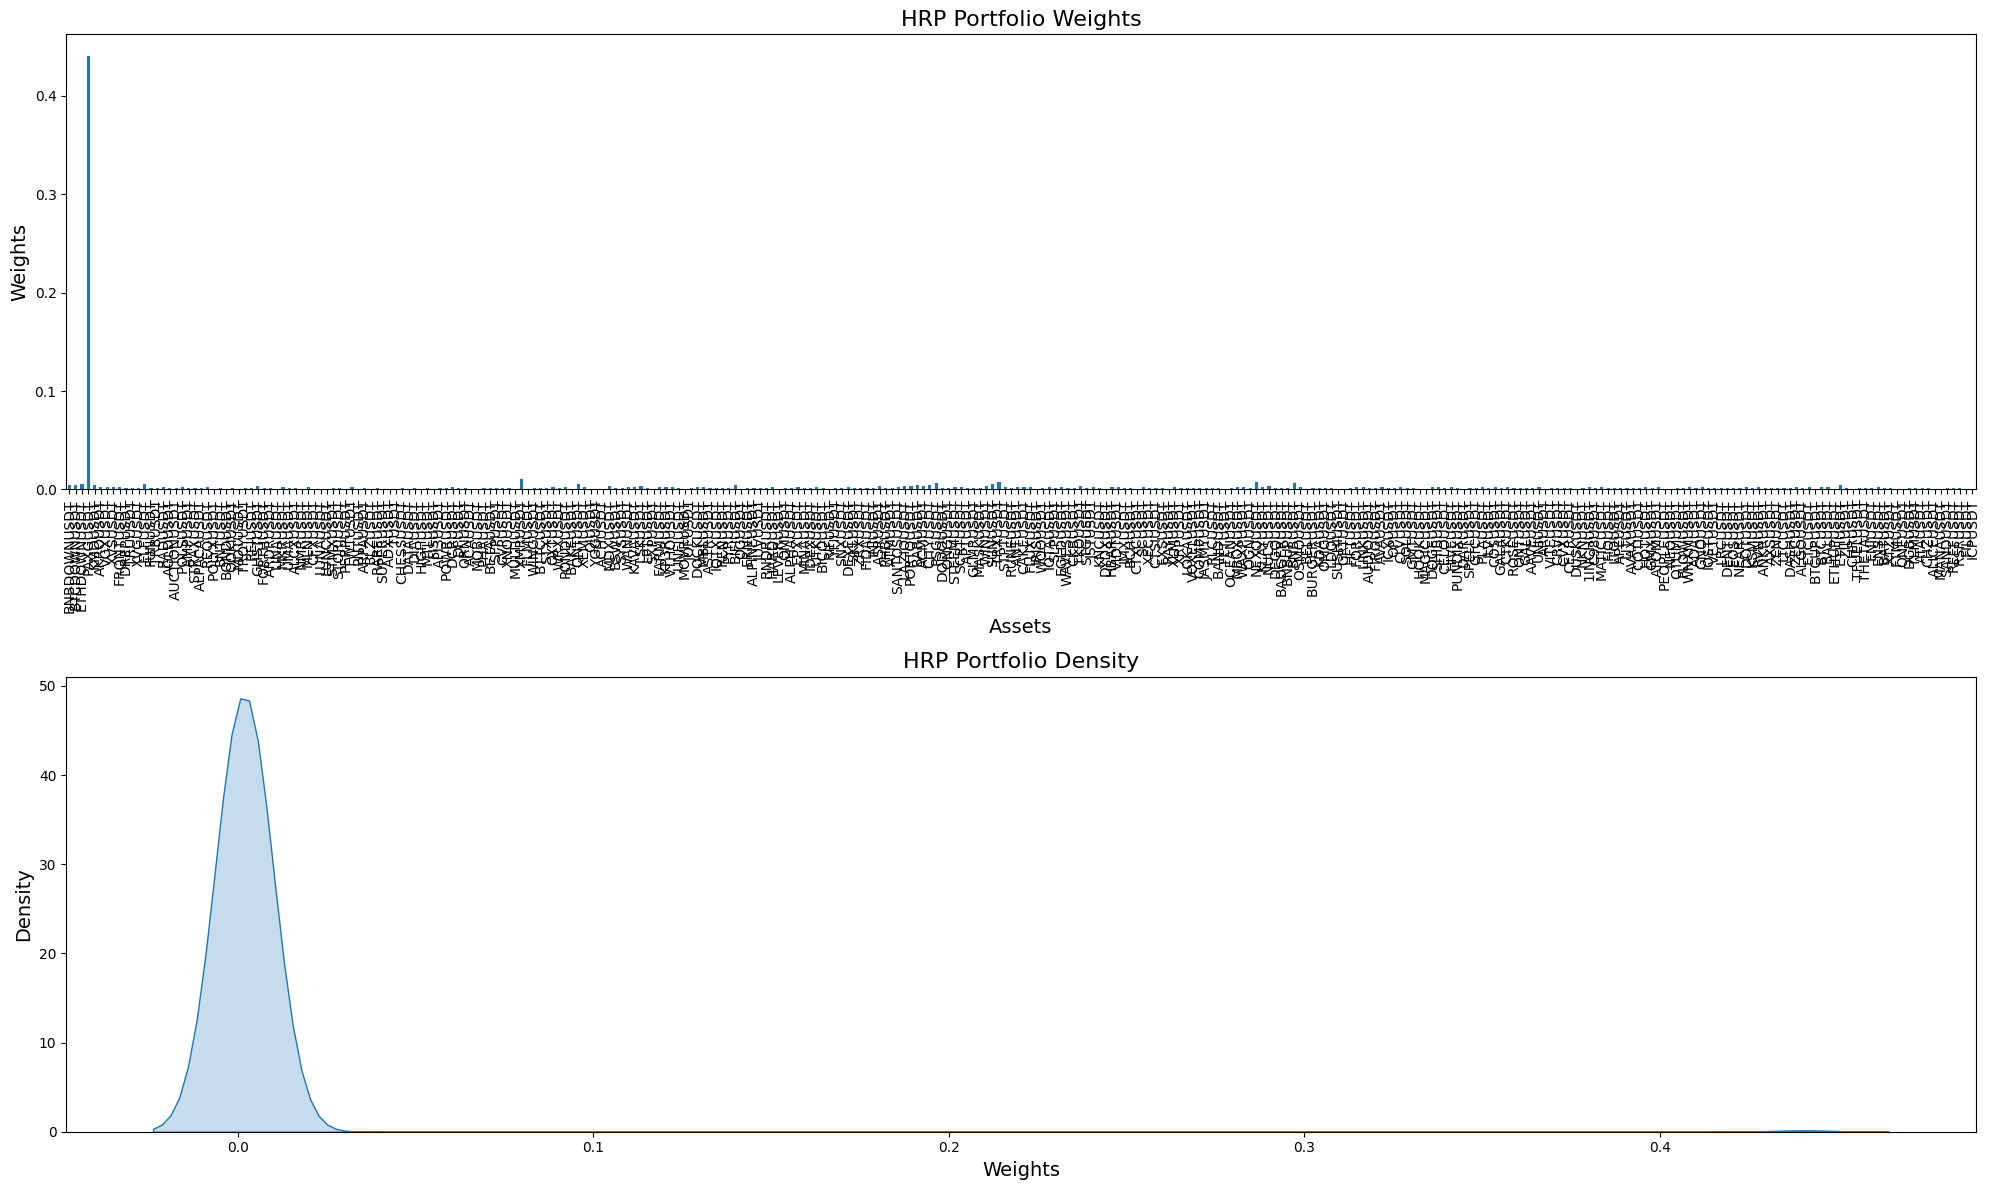

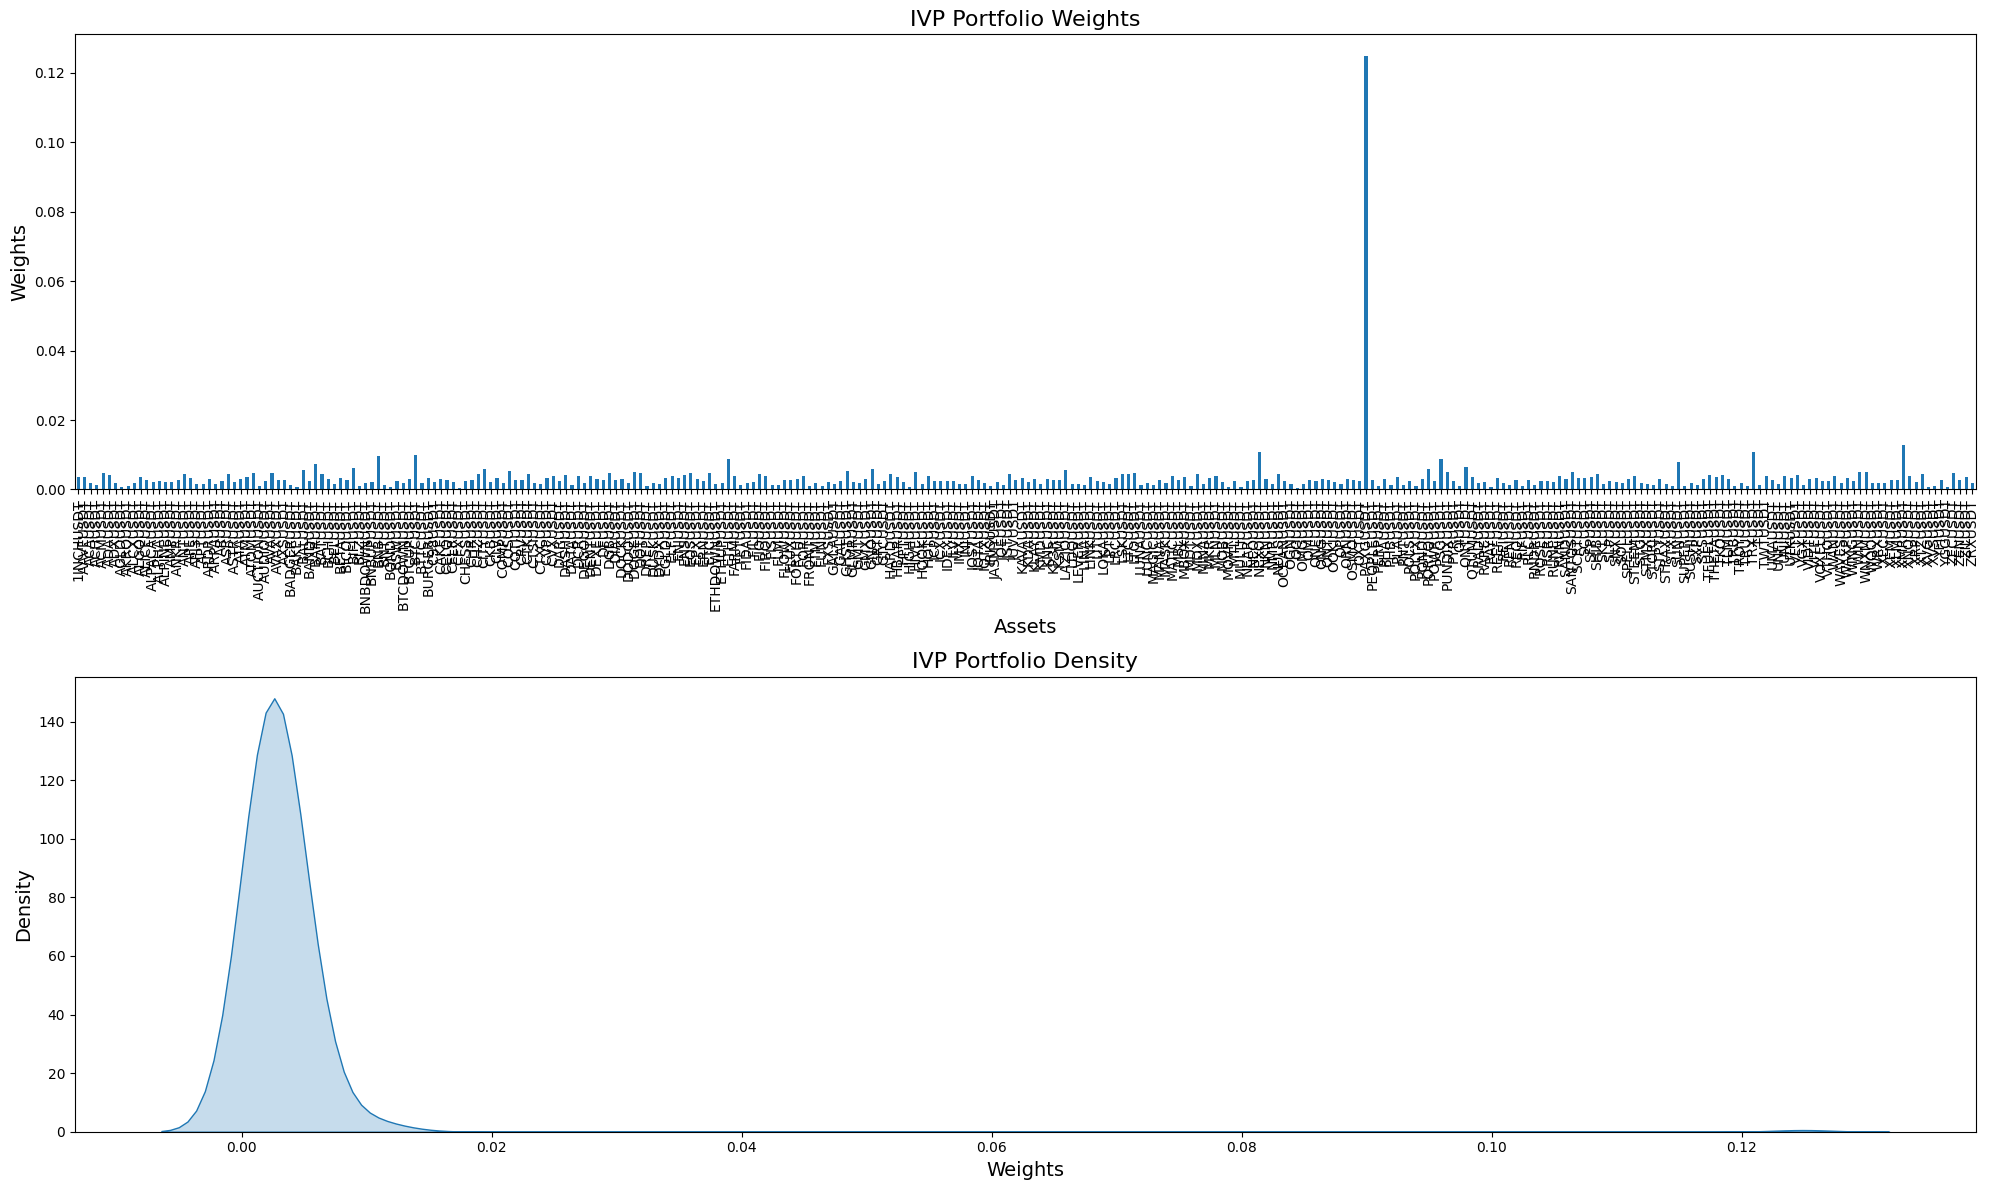

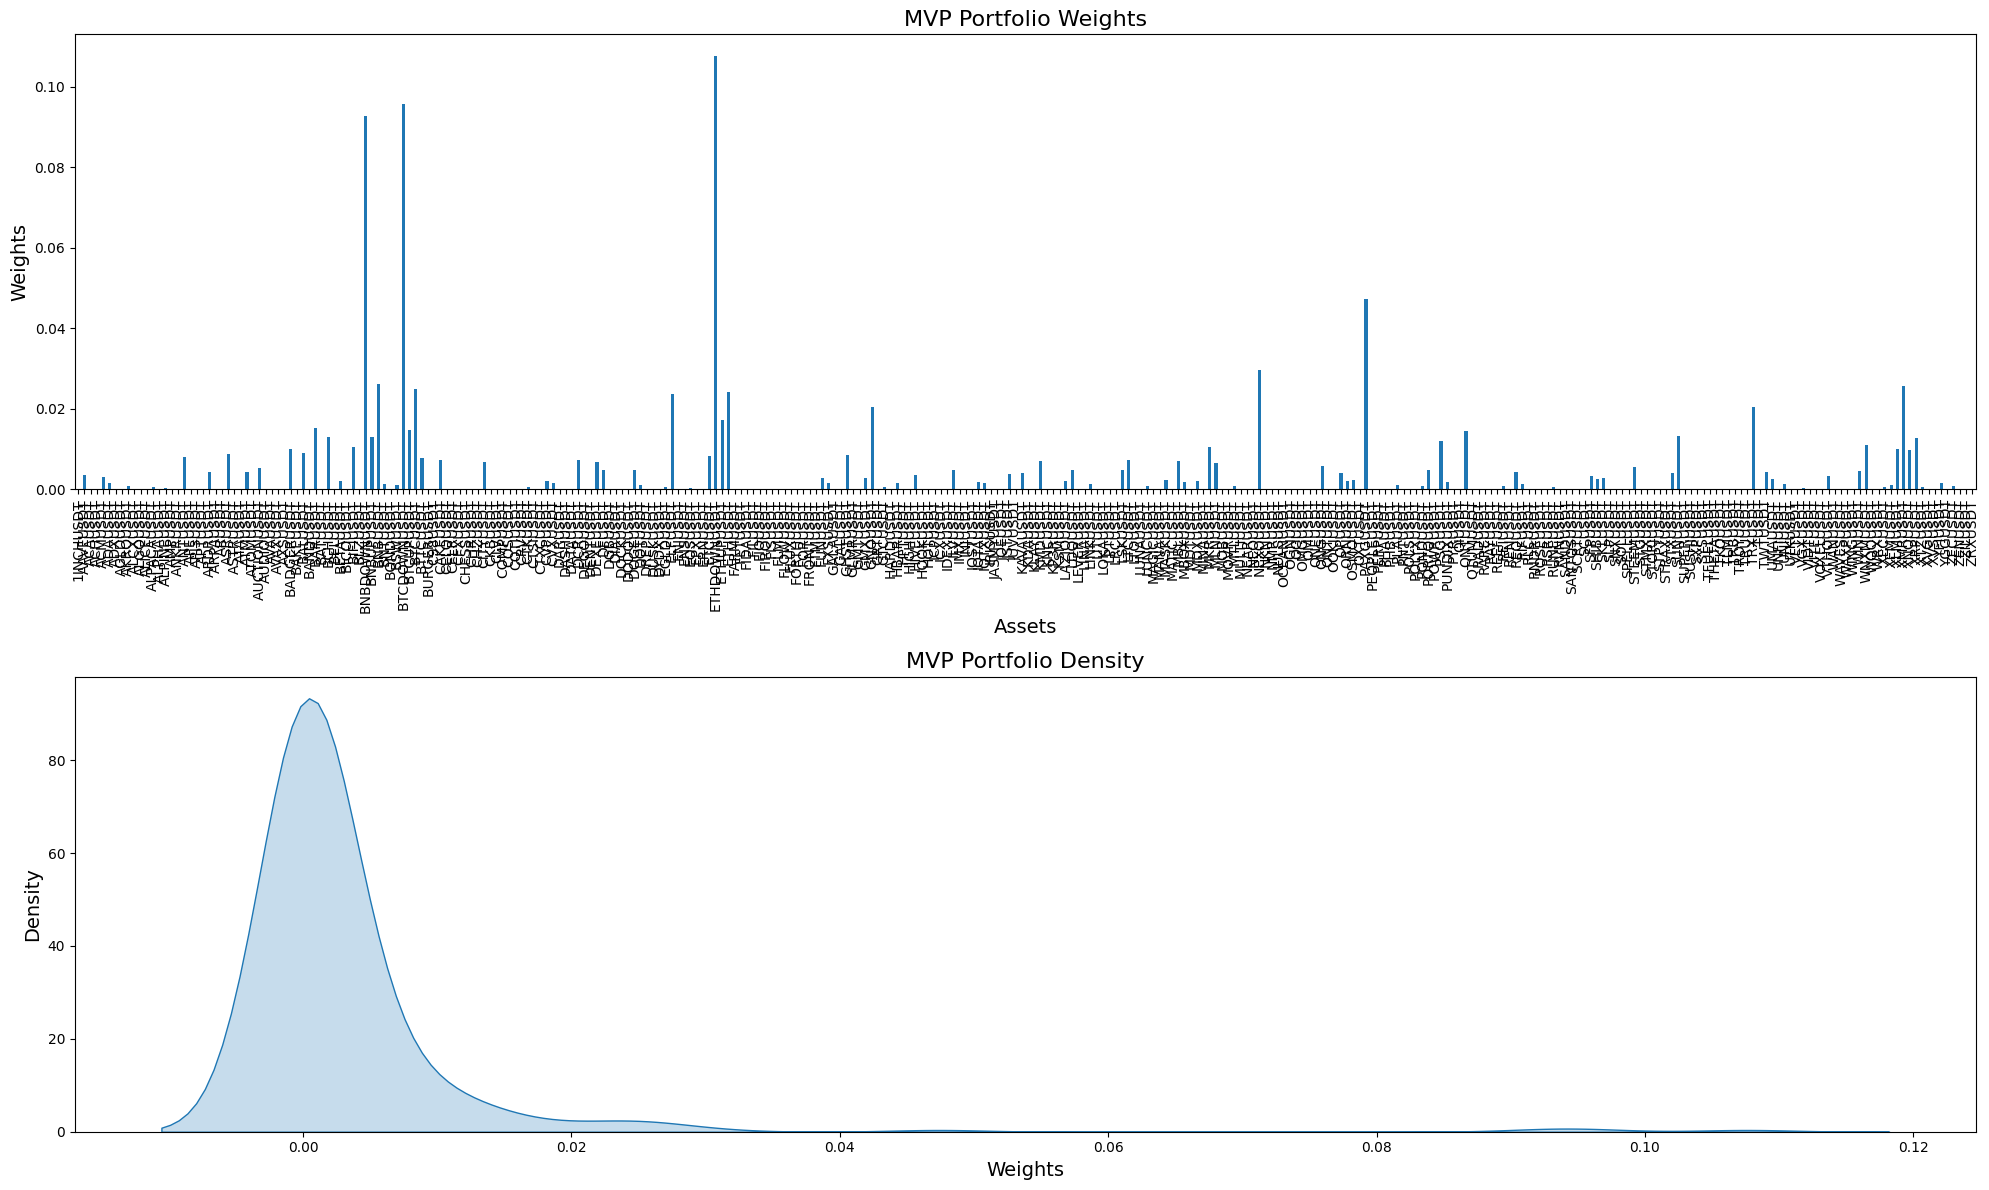

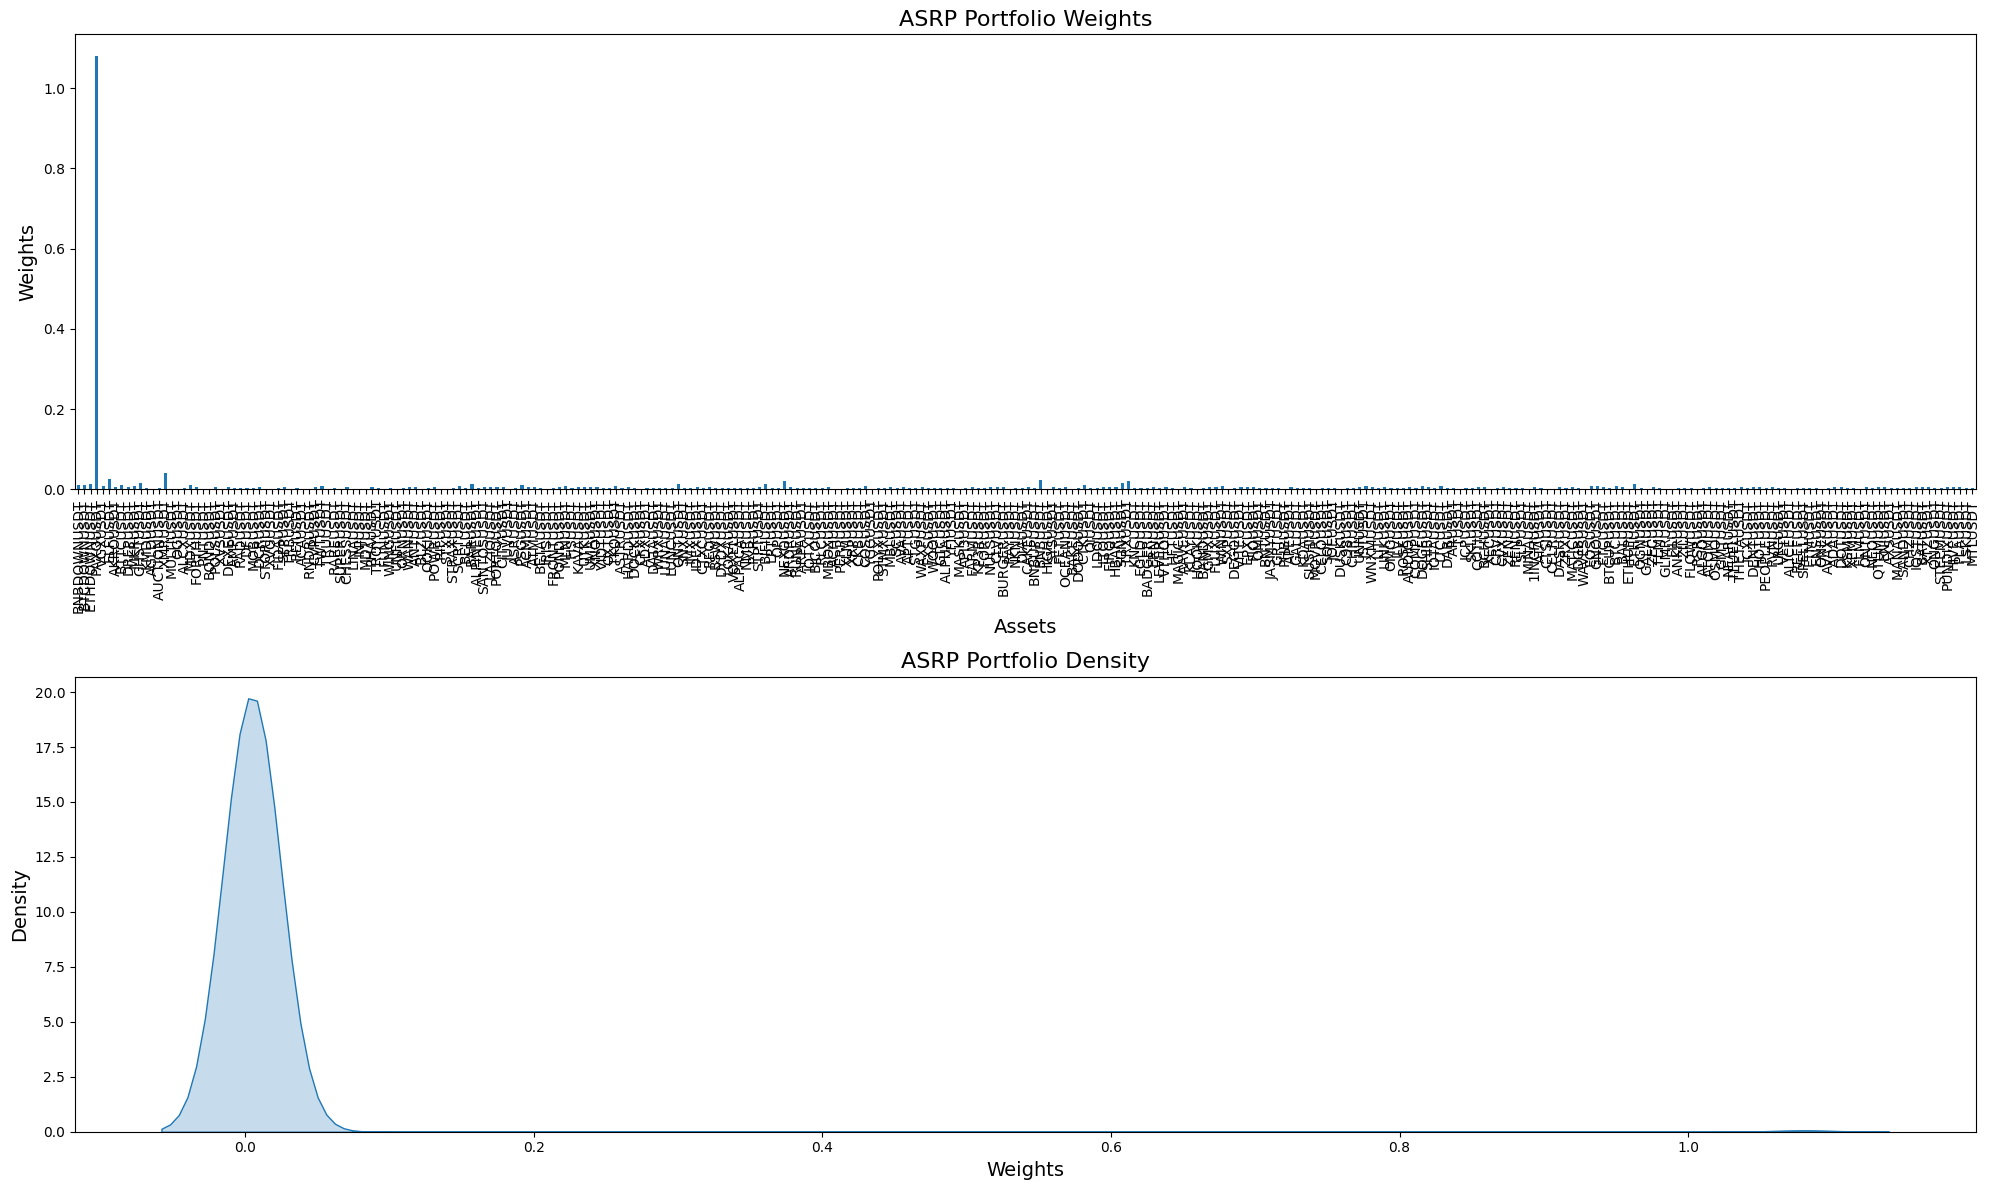

In [7]:
import seaborn as sns

strategies = {"HRP": hrp_weights, "IVP": ivp_weights, "MVP": mvp_weights, 'ASRP':asrp_weights}

for strategy, weights in strategies.items():
    fig, axes = plt.subplots(2, 1, figsize=(20, 12))
    
    weights.plot(kind="bar", ax=axes[0])
    axes[0].set_title(f"{strategy} Portfolio Weights", fontsize=16)
    axes[0].set_xlabel("Assets", fontsize=14)
    axes[0].set_ylabel("Weights", fontsize=14)
    
    sns.kdeplot(weights, ax=axes[1], fill=True)
    axes[1].set_title(f"{strategy} Portfolio Density", fontsize=16)
    axes[1].set_xlabel("Weights", fontsize=14)
    axes[1].set_ylabel("Density", fontsize=14)
    
    plt.tight_layout()
    plt.show()

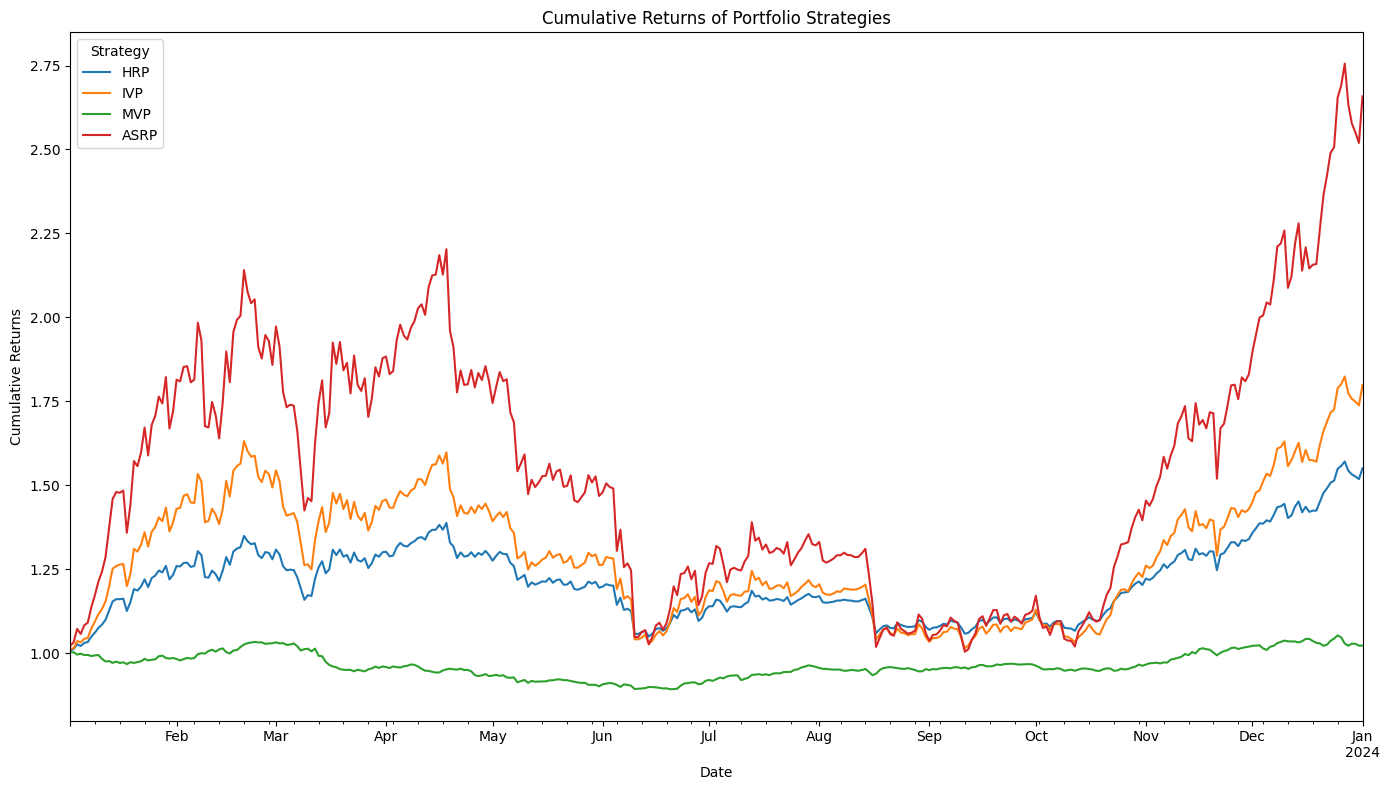

In [8]:
def calculate_cumulative_returns(returns_matrix, weights):
    """
    Calculate cumulative returns for a portfolio given returns and weights.

    Parameters:
    - returns_matrix: DataFrame of asset returns
    - weights: Series of portfolio weights

    Returns:
    - Series of cumulative returns
    """
    weighted_returns = (returns_matrix * weights).sum(axis=1)
    cumulative_returns = (1 + weighted_returns).cumprod()
    return cumulative_returns

hrp_cumulative = calculate_cumulative_returns(filtered_returns_matrix_post_2023, hrp_weights)
ivp_cumulative = calculate_cumulative_returns(filtered_returns_matrix_post_2023, ivp_weights)
mvp_cumulative = calculate_cumulative_returns(filtered_returns_matrix_post_2023, mvp_weights)
asrp_cumulative = calculate_cumulative_returns(filtered_returns_matrix_post_2023, asrp_weights)

cumulative_returns = pd.DataFrame({
    "HRP": hrp_cumulative,
    "IVP": ivp_cumulative,
    "MVP": mvp_cumulative,
    "ASRP": asrp_cumulative
})

cumulative_returns.plot(figsize=(14, 8), title="Cumulative Returns of Portfolio Strategies")
plt.xlabel("Date")
plt.ylabel("Cumulative Returns")
plt.legend(title="Strategy")
plt.tight_layout()
plt.show()
